## App review classification using XLNet model 

### Import the necessary libraries


In [12]:
import transformers
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import XLNetTokenizer
from transformers import TFXLNetForSequenceClassification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

### Load the Dataset

In [13]:
df = pd.read_csv('randomized_balanced.csv')
df.head()

,review,label
0,Seems more transparent & meaningful issues.,rating
1,The best app for editing texts,rating
2,It seems like it would be a great addition to ...,feature request
3,Its really fun and any age can play it and enj...,user experience
4,"Hey whatsApp , atomic_number_53 am experiancin...",bug report


## Start of Preprocessing

In [14]:
df['count'] = df['review'].apply(lambda x: len(x.split())) # encode the class labels
df.head()

,review,label,count
0,Seems more transparent & meaningful issues.,rating,6
1,The best app for editing texts,rating,6
2,It seems like it would be a great addition to ...,feature request,27
3,Its really fun and any age can play it and enj...,user experience,20
4,"Hey whatsApp , atomic_number_53 am experiancin...",bug report,43


### Get the number of word distrubution in the dataset

<Figure size 800x800 with 0 Axes>

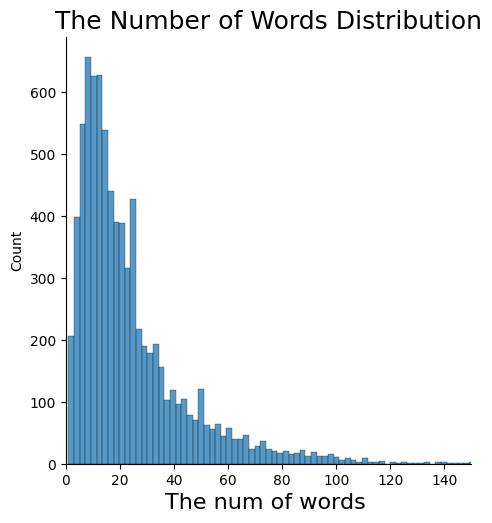

In [15]:
plt.figure(figsize= (8, 8))

sns.displot(df['count'])

plt.xlim(0, 150)

plt.xlabel('The num of words ', fontsize = 16)
plt.title("The Number of Words Distribution", fontsize = 18)
plt.show()

### Assign a Unique Integer for each target Class

In [16]:
df['encoded_text'] = df['label'].astype('category').cat.codes

df.head(10)

,review,label,count,encoded_text
0,Seems more transparent & meaningful issues.,rating,6,2
1,The best app for editing texts,rating,6,2
2,It seems like it would be a great addition to ...,feature request,27,1
3,Its really fun and any age can play it and enj...,user experience,20,3
4,"Hey whatsApp , atomic_number_53 am experiancin...",bug report,43,0
5,Good app really really Best app Thanks Faceboo...,rating,9,2
6,I think we should get more.,feature request,6,1
7,No option for dark mode on my Motorola g5 stylus,feature request,10,1
8,atomic_number_53 gave it a 4 star because I co...,bug report,19,0
9,"Not what it use to be, too many ads. Not enoug...",user experience,47,3


### Convert the reviews and labels to lists for further processing

In [17]:
data_texts = df['review'].to_list()

data_labels = df['encoded_text'].to_list()

### Split the data into training, validation, and testing sets


In [18]:
train_texts, temp_data, train_labels, temp_labels = train_test_split(data_texts, data_labels, test_size = 0.5, random_state = 0)
val_texts, test_data, val_labels, test_labels = train_test_split(temp_data, temp_labels, test_size=0.5, random_state= 0)

## Initialize the Tokenizer and Encode the Sets

In [19]:
# Load the XLNet tokenizer
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

# Tokenize and encode the datasets
def encode_texts(text_list):
    encoding = tokenizer(text_list, max_length=128, truncation=True, padding='max_length', return_tensors='tf')
    return encoding

train_encodings = encode_texts(train_texts) # encode the training data
val_encodings = encode_texts(val_texts) # encode the validation data
test_encodings = encode_texts(test_data) # encode the test data

### Convert Tokenized encodings into TensorFlow datasets

In [20]:
# Create the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask']},
    train_labels
))

# Create the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': val_encodings['input_ids'], 'attention_mask': val_encodings['attention_mask']},
    val_labels
))

# Create the test dataset
test_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask']},
    test_labels
))


## Load the XLNet Model 

In [21]:
# Number of classes
num_classes = 4

# Load the XLNet model
model = TFXLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=num_classes)

C:\Users\alpya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetForSequenceClassification: ['lm_loss']
- This IS expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model that 

### Define the parameters of the model and train the model

In [22]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5) # define the optimizer
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) # define the loss function
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy') # define the evaluation metric

model.compile(optimizer=optimizer, loss=loss, metrics=[metric]) # compile the model

# Train the model
history = model.fit(train_dataset.batch(8), epochs=5, batch_size=8,
                    validation_data=val_dataset.batch(8))


Epoch 1/5
500/500 [==============================] - 853s 2s/step - loss: 0.9701 - accuracy: 0.5970 - val_loss: 0.6853 - val_accuracy: 0.7300
Epoch 2/5
500/500 [==============================] - 846s 2s/step - loss: 0.6095 - accuracy: 0.7720 - val_loss: 0.6274 - val_accuracy: 0.7640
Epoch 3/5
500/500 [==============================] - 834s 2s/step - loss: 0.4288 - accuracy: 0.8445 - val_loss: 0.5935 - val_accuracy: 0.7980
Epoch 4/5
500/500 [==============================] - 839s 2s/step - loss: 0.2565 - accuracy: 0.9090 - val_loss: 0.6430 - val_accuracy: 0.8085
Epoch 5/5
500/500 [==============================] - 836s 2s/step - loss: 0.1956 - accuracy: 0.9310 - val_loss: 0.6541 - val_accuracy: 0.8250


### Evaluate the model on the test set

In [23]:
test_loss, test_acc = model.evaluate(test_dataset.batch(8)) # evaluate the model
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}") # print the test accuracy and loss


250/250 [==============================] - 98s 392ms/step - loss: 0.5995 - accuracy: 0.8445
Test Loss: 0.5995258092880249, Test Accuracy: 0.8445000052452087


### Make predictions on the test set and print the classification report

In [24]:
# Make predictions
predictions = model.predict(test_dataset.batch(8)) # make predictions
predicted_classes = np.argmax(predictions.logits, axis=1) # get the predicted class labels

accuracy = accuracy_score(test_labels, predicted_classes) # calculate the accuracy
precision = precision_score(test_labels, predicted_classes, average=None) # calculate the precision
recall = recall_score(test_labels, predicted_classes, average=None) # calculate the recall 
f1 = f1_score(test_labels, predicted_classes, average=None) # calculate the F1 score

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

250/250 [==============================] - 103s 407ms/step
Accuracy: 0.8445
Precision: [0.86806883 0.84824903 0.81102362 0.85054945]
Recall: [0.8990099  0.84169884 0.84773663 0.78818737]
F1 Score: [0.88326848 0.84496124 0.82897384 0.81818182]
